<a href="https://colab.research.google.com/github/Gr3gP/Misc-Projects/blob/main/Netflix_Recommendation_System.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Building a Recommendation System Tutorial 

found here: https://pub.towardsai.net/recommendation-system-in-depth-tutorial-with-python-for-netflix-using-collaborative-filtering-533ff8a0e444


In [ ]:
# Download datasets
!wget https://zenodo.org/record/4556134/files/combined_data_4.txt?download=1
!wget https://raw.githubusercontent.com/towardsai/tutorials/master/recommendation_system_tutorial/movie_titles.csv
!wget https://raw.githubusercontent.com/towardsai/tutorials/master/recommendation_system_tutorial/new_features.csv

--2021-05-15 19:34:23--  https://zenodo.org/record/4556134/files/combined_data_4.txt?download=1
Resolving zenodo.org (zenodo.org)... 137.138.76.77
Connecting to zenodo.org (zenodo.org)|137.138.76.77|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 552537802 (527M) [text/plain]
Saving to: ‘combined_data_4.txt?download=1’

combined_data_4.txt 100%[===================>] 526.94M  12.7MB/s    in 39s     

2021-05-15 19:35:03 (13.6 MB/s) - ‘combined_data_4.txt?download=1’ saved [552537802/552537802]

--2021-05-15 19:35:03--  https://raw.githubusercontent.com/towardsai/tutorials/master/recommendation_system_tutorial/movie_titles.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 577547 (564K) [text/plain]
Saving to: ‘movie_titles.csv’

mov

In [ ]:
!pip install scikit-surprise

     |████████████████████████████████| 11.8MB 5.1MB/s 
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.1-cp37-cp37m-linux_x86_64.whl size=1617652 sha256=c63a520d41893b2bced08f24d38ea1bd3e56dbddc3dd2fc7f12b61b63ed81649
  Stored in directory: /root/.cache/pip/wheels/78/9c/3d/41b419c9d2aff5b6e2b4c0fc8d25c538202834058f9ed110d0
Successfully built scikit-surprise


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
from datetime import datetime
import pandas as pd
import numpy as np
import seaborn as sns
import os
import random
import matplotlib
import matplotlib.pyplot as plt
from scipy import sparse
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import mean_squared_error

import xgboost as xgb
from surprise import Reader, Dataset
from surprise import BaselineOnly
from surprise import KNNBaseline
from surprise import SVD
from surprise import SVDpp
from surprise.model_selection import GridSearchCV

#EDA

**Load the Datasets**

In [ ]:
def load_data():
    netflix_csv_file = open('netflix_rating.csv', mode= 'w')
    rating_files = ['combined_data_4.txt?download=1']
    for file in rating_files:
        with open(file) as f:
            for line in f:
                line = line.strip()
                if line.endswith(':'):
                    movie_id = line.replace(':', "")
                else:
                    row_data = []
                    row_data = [item for item in line.split(',')]
                    row_data.insert(0, movie_id)
                    netflix_csv_file.write(','.join(row_data))
                    netflix_csv_file.write('\n')
    
    netflix_csv_file.close()
    df = pd.read_csv('netflix_rating.csv', sep=",", names = ["movie_id","customer_id", "rating", "date"])
    return df

In [ ]:
#Display rating data
netflix_rating_df = load_data()
netflix_rating_df
netflix_rating_df.head()

,movie_id,customer_id,rating,date
0,13368,2385003,4,2004-07-08
1,13368,659432,3,2005-03-16
2,13368,751812,2,2002-12-16
3,13368,2625420,2,2004-05-25
4,13368,1650301,1,2005-08-30


In [ ]:
netflix_rating_df.duplicated(['movie_id', 'customer_id', 'rating', 'date']).sum()

0

**Split data into train and test sets**

In [ ]:
split_value = int(len(netflix_rating_df) * 0.80)
train_data = netflix_rating_df[:split_value]
test_data = netflix_rating_df[split_value:]

**Analysis**

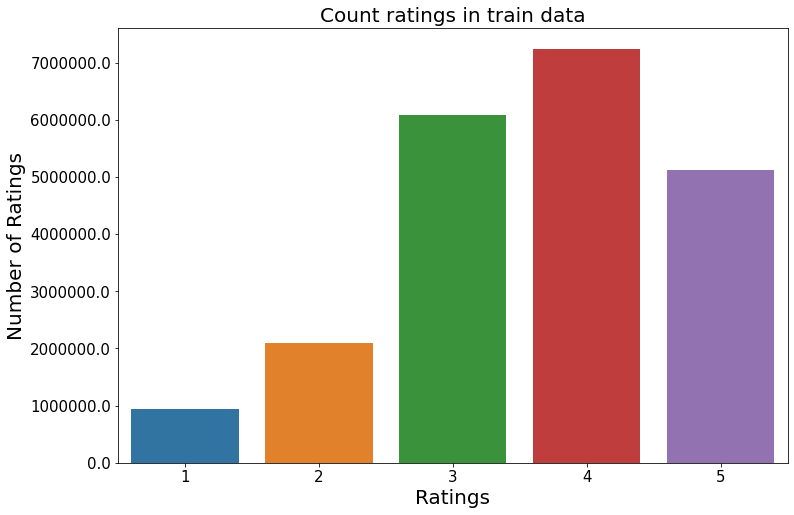

In [ ]:
plt.figure(figsize=(12,8))
ax = sns.countplot(x='rating', data=train_data)

ax.set_yticklabels([num for num in ax.get_yticks()])

plt.tick_params(labelsize=15)
plt.title('Count ratings in train data', fontsize=20)
plt.xlabel('Ratings', fontsize=20)
plt.ylabel('Number of Ratings', fontsize=20)
plt.show()

**User item spares Matrix**

A User-item sparse matrix is an object that contains item values in columns and users' values in rows. The rating of users is contained in the cell.

In [ ]:
def get_user_sparse_matrix(df):
    sparse_data = sparse.csr_matrix((df.rating, (df.customer_id, df.movie_id)))
    return sparse_data

In [ ]:
#sparse matrix for training data
train_sparse_data = get_user_sparse_matrix(train_data)

#sparse matrix for test data
test_sparse_data = get_user_sparse_matrix(test_data)

In [ ]:
#find the average global movie rating
global_average_rating = train_sparse_data.sum()/train_sparse_data.count_nonzero()
print('Global average rating: {}'.format(global_average_rating))

Global average rating: 3.6291294662291467


In [ ]:
#function to calculate GAR from the sparse matrix
def get_average_rating(sparse_matrix, is_user):
    ax = 1 if is_user else 0
    sum_of_ratings = sparse_matrix.sum(axis=ax).A1
    num_of_ratings = (sparse_matrix != 0).sum(axis=ax).A1
    rows, cols = sparse_matrix.shape
    average_ratings = {i: sum_of_ratings[i]/num_of_ratings[i] for i in range(rows if is_user else cols) if num_of_ratings[i] != 0}
    return average_ratings

In [ ]:
#Calc Average user rating 
average_user_rating = get_average_rating(train_sparse_data, True)

In [ ]:
#Calc Average movie rating
average_movie_rating = get_average_rating(train_sparse_data, False)

**Cold Start Problem**

When users are brand nwew they have almost no data to use. In our case, 1% of users will be cold starts and have no rating available. 

For movies, 20% of our movies will be from a cold start(have no rating)

In [ ]:
#find the number of cold start users
total_users = len(np.unique(netflix_rating_df['customer_id']))
train_users = len(average_user_rating)
uncommonUsers = total_users - train_users

print('total num of users: {}'.format(total_users))
print('Num of users in train data: {}'.format(train_users))
print('Num of users not present in train_data: {}({}%)'.format(uncommonUsers, np.round((uncommonUsers/total_users)*100), 2))

total num of users: 475601
Num of users in train data: 473014
Num of users not present in train_data: 2587(1.0%)


In [ ]:
#find the number of cold start movies
total_movies = len(np.unique(netflix_rating_df['movie_id']))
train_movies = len(average_movie_rating)
uncommonMovies = total_movies - train_movies

print('Total number of movies: {}'.format(total_movies))
print('num of movies in train_data: {}'.format(train_movies))
print('num of movies not present in train_data: {}({}%)'.format(uncommonMovies, np.round((uncommonMovies/total_movies)*100), 2))

Total number of movies: 4403
num of movies in train_data: 3515
num of movies not present in train_data: 888(20.0%)


**User Similarity Computation for Top 100 Users**

In [ ]:
def compute_user_similarity(sparse_matrix, limit=100):
    row_index, col_index = sparse_matrix.nonzero()
    row = np.unique(row_index)
    similar_arr = np.zeros(61700).reshape(617,100)

    for row in row[:limit]:
        sim = cosine_similarity(sparse_matrix.getrow(row), train_sparse_data).ravel()
        similar_indices = sim.argsort()[-limit:]
        similar = sim[similar_indices]
        similar_arr[row] = similar

    return similar_arr

In [ ]:
similar_user_matrix = compute_user_similarity(train_sparse_data, 100)

In [ ]:
similar_user_matrix[0]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [ ]:
#load movie titels
movie_titles_df = pd.read_csv("movie_titles.csv",sep = ",",
                              header = None, names=['movie_id', 'year_of_release', 'movie_title'],
                              index_col = "movie_id", encoding = "iso8859_2")
movie_titles_df.head()

,year_of_release,movie_title
movie_id,,
1,2003.0,Dinosaur Planet
2,2004.0,Isle of Man TT 2004 Review
3,1997.0,Character
4,1994.0,Paula Abdul's Get Up & Dance
5,2004.0,The Rise and Fall of ECW


In [ ]:
#compute movie similarity matrix
def compute_movie_similarity_count(sprase_matrix, movie_titles_df, movie_id):
    similarity = cosine_similarity(sprase_matrix.T, dense_output= False)
    num_of_similar_movies = movie_titles_df.loc[movie_id][1], similarity[movie_id].count_nonzero()
    return num_of_similar_movies

In [ ]:
similar_movies = compute_movie_similarity_count(train_sparse_data, movie_titles_df, 1775)
print("similar movies = {}".format(similar_movies))

similar movies = ('Dario Argento Collection: Vol. 1: Phenomena', 0)


In [ ]:
def get_sample_sparse_matrix(sparse_matrix, no_of_users, no_of_movies):
    users, movies, ratings = sparse.find(sparse_matrix)
    uniq_users = np.unique(users)
    uniq_movies = np.unique(movies)
    np.random.seed(15) 
    user = np.random.choice(uniq_users, no_of_users, replace = False)
    movie = np.random.choice(uniq_movies, no_of_movies, replace = True)
    mask = np.logical_and(np.isin(users, user), np.isin(movies, movie))
    sparse_matrix = sparse.csr_matrix((ratings[mask], (users[mask], movies[mask])), 
                                                     shape = (max(user)+1, max(movie)+1))
    return sparse_matrix

In [ ]:
#sample sparse matrix for training data
train_sample_sparse_matrix = get_sample_sparse_matrix(train_sparse_data, 400, 40)

#sample sparse matrix for test data
test_sparse_matrix_matrix = get_sample_sparse_matrix(test_sparse_data, 200, 20)

**Generic Method for Generating Similar Features**

In [ ]:
def create_new_similar_features(sample_sparse_matrix):
    global_average_rating = get_average_rating(sample_sparse_matrix, False)
    global_average_users = get_average_rating(sample_sparse_matrix, True)
    global_average_movies = get_average_rating(sample_sparse_matrix, False)
    sample_train_users, sample_train_movies, sample_train_ratings = sparse.find(sample_sparse_matrix)
    new_features_csv_file = open('new_features.csv', mode = 'w')

    for user, movie, rating in zip(sample_train_users, sample_train_movies, sample_train_ratings):
        similar_arr = list()
        similar_arr.append(user)
        similar_arr.append(movie)
        similar_arr.append(sample_sparse_matrix.sum()/sample_sparse_matrix.count_nonzero())

        similar_users = cosine_similarity(sample_sparse_matrix[user], sample_sparse_matrix).ravel()
        indices = np.argsort(-similar_users)[1:]
        ratings = sample_sparse_matrix[indices, movie].toarray().ravel()
        top_similar_user_ratings = list(ratings[ratings != 0][:5])
        top_similar_user_ratings.extend([global_average_rating[movie]] * (5 - len(ratings)))
        similar_arr.extend(top_similar_user_ratings)

        similar_movies = cosine_similarity(sample_sparse_matrix[:,movie].T, sample_sparse_matrix.T).ravel()
        similar_movie_indices = np.argsort(-similar_movies)[1:]
        similar_movie_ratings = sample_sparse_matrix[user, similar_movie_indices].toarray().ravel()
        top_similar_movie_ratings = list(similar_movie_ratings[similar_movie_ratings != 0][:5])
        top_similar_movie_ratings.extend([global_average_users[user]] * (5 - len(similar_movie_ratings)))
        similar_arr.extend(top_similar_user_ratings)

        similar_arr.append(global_average_users[user])
        similar_arr.append(global_average_movies[movie])
        similar_arr.append(rating)

        new_features_csv_file.write(",".join(map(str, similar_arr)))
        new_features_csv_file.write("\n")


    new_features_csv_file.close()
    new_features_df = pd.read_csv('new_features.csv', names = ["user_id", "movie_id", "gloabl_average", "similar_user_rating1", 
                                                               "similar_user_rating2", "similar_user_rating3", 
                                                               "similar_user_rating4", "similar_user_rating5", 
                                                               "similar_movie_rating1", "similar_movie_rating2", 
                                                               "similar_movie_rating3", "similar_movie_rating4", 
                                                               "similar_movie_rating5", "user_average", 
                                                               "movie_average", "rating"])
    return new_features_df

In [ ]:
#generate similar features
train_new_similar_features = create_new_similar_features(train_sample_sparse_matrix)

train_new_similar_features = train_new_similar_features.fillna(0)
train_new_similar_features.head()

,user_id,movie_id,gloabl_average,similar_user_rating1,similar_user_rating2,similar_user_rating3,similar_user_rating4,similar_user_rating5,similar_movie_rating1,similar_movie_rating2,similar_movie_rating3,similar_movie_rating4,similar_movie_rating5,user_average,movie_average,rating
0,368756,13393,3.392157,4.0,4.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2593137,13495,3.392157,4.0,4.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,96842,13602,3.392157,3.0,5.0,5.0,3.0,5.0,5.0,5.0,4.5,5.0,0.0,0.0,0.0,0.0
3,486048,13602,3.392157,3.0,5.0,5.0,3.0,5.0,5.0,3.0,4.5,3.0,0.0,0.0,0.0,0.0
4,940434,13602,3.392157,3.0,5.0,5.0,3.0,5.0,5.0,5.0,4.5,5.0,0.0,0.0,0.0,0.0


In [ ]:
#generate similar features for the test data
test_new_similar_features = create_new_similar_features(test_sparse_matrix_matrix)

test_new_similar_features = test_new_similar_features.fillna(0)
test_new_similar_features.head()

,user_id,movie_id,gloabl_average,similar_user_rating1,similar_user_rating2,similar_user_rating3,similar_user_rating4,similar_user_rating5,similar_movie_rating1,similar_movie_rating2,similar_movie_rating3,similar_movie_rating4,similar_movie_rating5,user_average,movie_average,rating
0,218348,16977,3.393939,4.0,1.0,5.0,4.0,3.0,4.0,1.0,5.0,4.0,3.0,5.000000,3.583333,5.0
1,482111,16977,3.393939,4.0,1.0,5.0,4.0,3.0,4.0,1.0,5.0,4.0,3.0,3.000000,3.583333,3.0
2,770495,16977,3.393939,4.0,1.0,5.0,4.0,3.0,4.0,1.0,5.0,4.0,3.0,4.000000,3.583333,4.0
3,1033930,16977,3.393939,2.0,1.0,3.0,4.0,4.0,2.0,1.0,3.0,4.0,4.0,2.666667,3.583333,3.0
4,1301848,16977,3.393939,4.0,1.0,5.0,4.0,3.0,4.0,1.0,5.0,4.0,3.0,4.000000,3.583333,4.0


#Build The Models

In [ ]:
x_train = train_new_similar_features.drop(['user_id', 'movie_id', 'rating'], axis = 1)

x_test = test_new_similar_features.drop(['user_id', 'movie_id', 'rating'], axis=1)

y_train = train_new_similar_features['rating']

y_test = test_new_similar_features['rating']

In [ ]:
def error_metrics(y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    return rmse

In [ ]:
clf = xgb.XGBRegressor(n_estimators= 100, silent= False, n_jobs = 10)
clf.fit(x_train, y_train)

[21:07:36] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
             n_jobs=10, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=False, subsample=1, verbosity=1)

In [ ]:
y_pred_test = clf.predict(x_test)

In [ ]:
rmse_test = error_metrics(y_test, y_pred_test)
print('RMSE = {}'.format(rmse_test))

RMSE = 0.3003599476206699


**Plot feature importance**

In [ ]:
def plot_importance(model, clf):
    fig = plt.figure(figsize=(8,6))
    ax = fig.add_axes([0,0,1,1])
    model.plot_importance(clf, ax=ax, height=0.3)
    plt.xlabel('F Score', fontsize=20)
    plt.ylabel('Features', fontsize=20)
    plt.title('Feature Importance', fontsize=20)
    plt.tick_params(labelsize=15)

    plt.show()

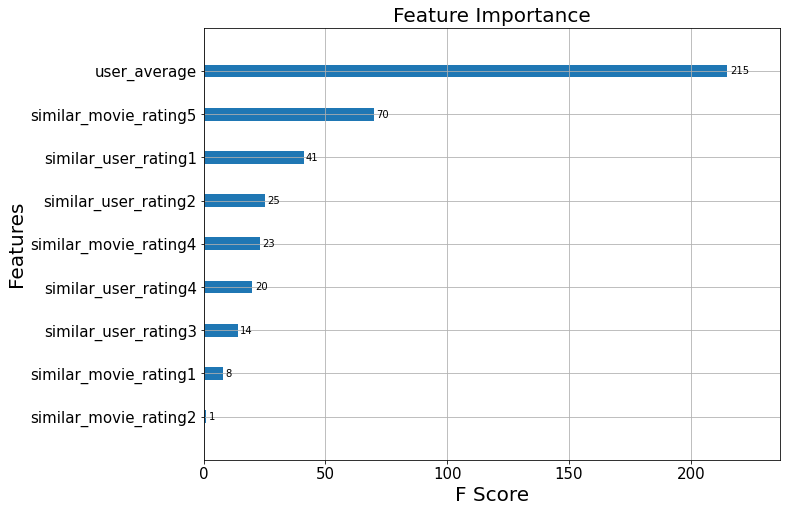

In [ ]:
plot_importance(xgb, clf)